In [1]:
%reset
import sys

# standard packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pickle as pkl
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from IPython.display import Image
import random
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import silhouette_score

working_dir = "~/Desktop/hif2gene"

%reload_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/numba/core/errors.py:144: UserWarning:

Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9



In [2]:
seed = 16
random.seed(seed)

# Pan-Cancer

In [3]:
# Load in pancancer HIF (already cleaned, NA removed)
pancancer_df = pd.read_csv("{0}/data/hifs/pancancer.hifs.labeled.csv".format(working_dir))

# Remove first column
pancancer_df = pancancer_df.drop(columns=['Unnamed: 0'])
pancancer_df.shape # includes HIFs, barcodes, cancer subtype

(2577, 609)

In [4]:
case_ids = pancancer_df[['CASE_ID']] # note: patient-level (one sample per patient)
cancer_subtypes = pancancer_df[['type']]
pancancer_hifs = pancancer_df.iloc[:,1:608]
print(pancancer_hifs.shape)
# pancancer_hifs.columns

(2577, 607)


In [5]:
# Standardize: mean = 0, variance = 1
pancancer_hifs_standardized = StandardScaler().fit_transform(pancancer_hifs)
# pancancer_hifs_standardized

In [7]:
colors = {
    'BRCA': '#f49ff2', 
    'STAD': '#4a91cd', 
    'LUAD': '#ea4253', 
    'LUSC': '#ec924a', 
    'SKCM': '#7c44cc' 
}

## UMAP

In [8]:
print(seed)
n_neighbors = 15
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, random_state=seed)
umap_embeddings = reducer.fit_transform(pancancer_hifs_standardized) # UMAP embeddings
umap_df = pd.DataFrame(data=umap_embeddings, columns=['UMAP 1', 'UMAP 2'])
umap_df['Cancer Subtype'] = cancer_subtypes
umap_df['Case ID'] = case_ids
# umap_df

16


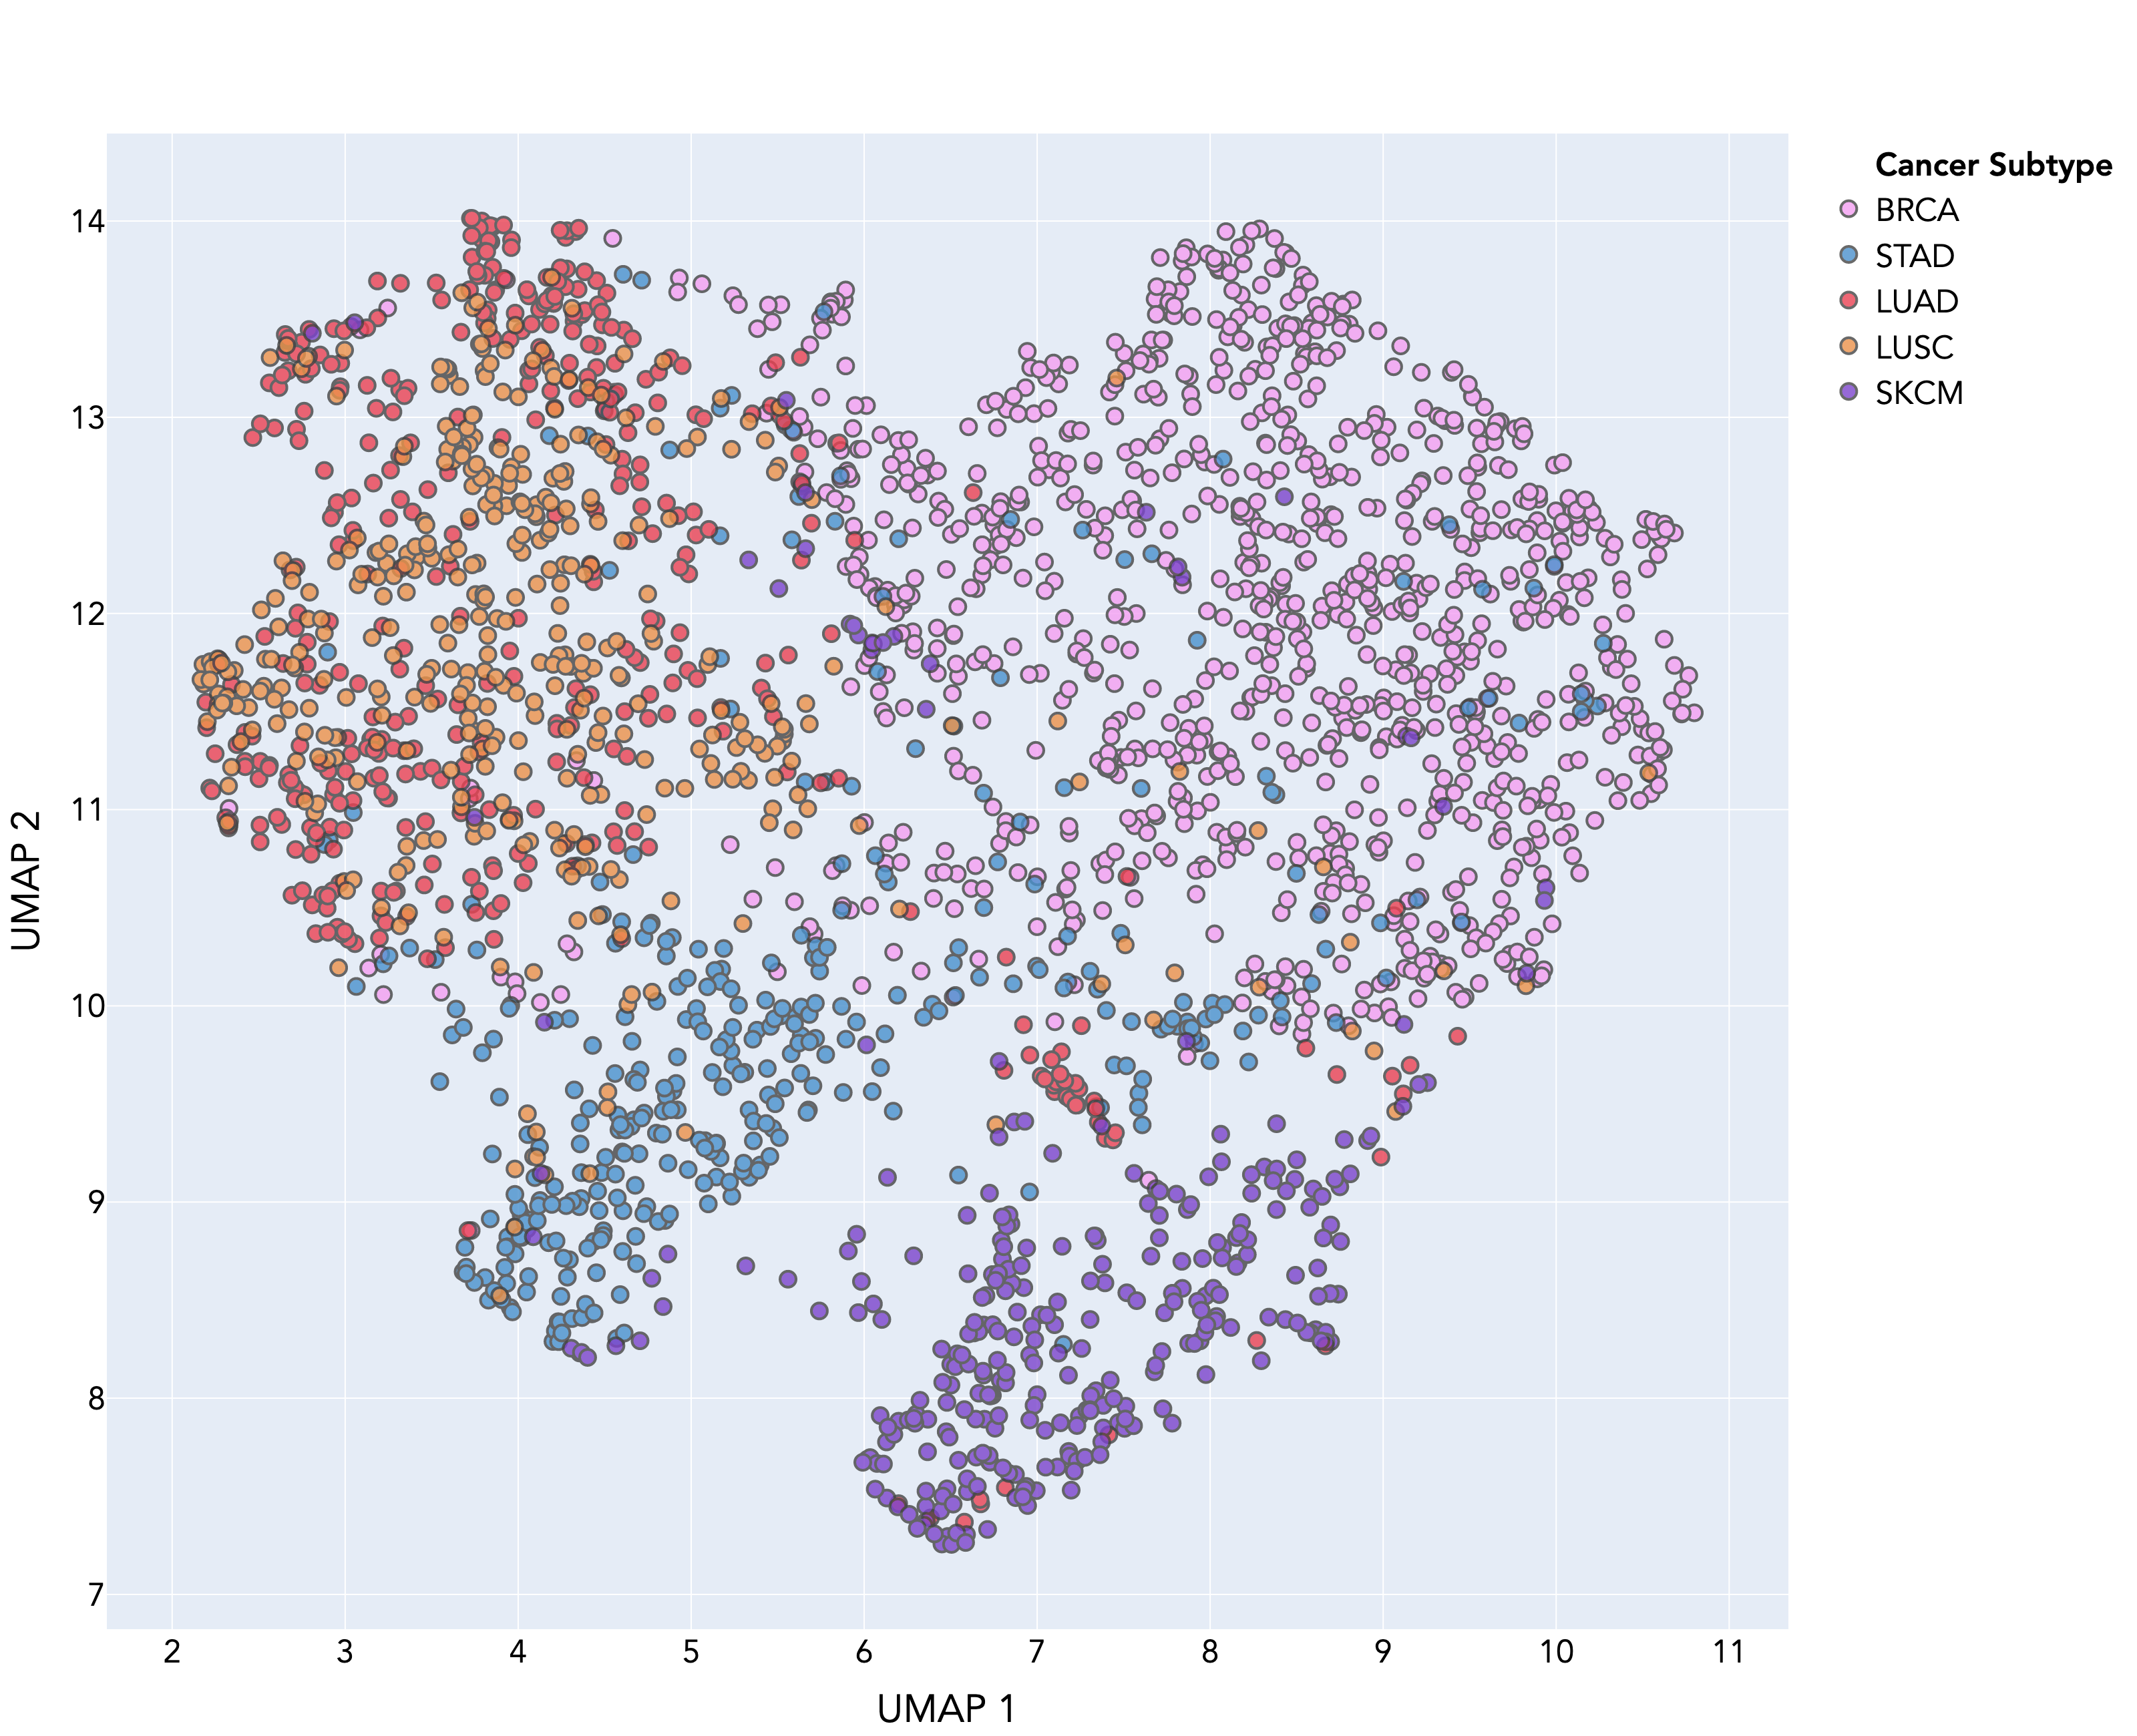

In [9]:
# Visualize 
dummy_trace = go.Scatter(
    x=[None], y=[None],
    name='<b>Cancer Subtype</b>',
    opacity = 0,
    line={'color': 'rgba(0, 0, 0, 0)'}
)
data = [dummy_trace]

for cancer_subtype in colors.keys():
    umap_df_filtered = umap_df[umap_df['Cancer Subtype'] == cancer_subtype]
    umap1 = np.array(umap_df_filtered['UMAP 1'])
    umap2 = np.array(umap_df_filtered['UMAP 2'])
    
    trace = go.Scatter(
        x=umap1,
        y=umap2,
        mode='markers',
        marker=dict(color=[colors[cancer_subtype]]*len(umap1)),
        opacity=0.8,
        name="{0}".format(cancer_subtype),
        hovertext=np.array(umap_df_filtered['Case ID'])
    )
    data.append(trace)

fig = go.Figure(data=data)

fig.update_layout(
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2",
    font=dict(
        family="Avenir",
        size=24,
        color="black"
    ),
    width=1400,
    height=1075
)

fig.update_traces(marker_line_width=2, marker_size=12)
img_bytes = fig.to_image(format="png", width=1600, height=1300, scale=2)
Image(img_bytes)

## Cluster Metrics on UMAP Data


In [10]:
# K Means on UMAP data
kmeans = KMeans(n_clusters=4, random_state=seed, init='k-means++').fit(umap_df.iloc[:,0:2])
len(kmeans.labels_)

2577

In [11]:
umap_df['K-Means Label'] = kmeans.labels_
# umap_df

In [12]:
# Merge LUAD / LUSC into one group
umap_df.loc[umap_df['Cancer Subtype'] == 'LUAD', 'Cancer Subtype'] = 'NSCLC'
umap_df.loc[umap_df['Cancer Subtype'] == 'LUSC', 'Cancer Subtype'] = 'NSCLC'

In [13]:
homogeneity_score(umap_df['Cancer Subtype'], umap_df['K-Means Label'])

0.4847606658331613

In [14]:
completeness_score(umap_df['Cancer Subtype'], umap_df['K-Means Label'])

0.46105232291979414

In [15]:
v_measure_score(umap_df['Cancer Subtype'], umap_df['K-Means Label'])

0.4726093502632219

In [16]:
silhouette_score(umap_df.iloc[:,0:2], umap_df['K-Means Label'])

0.4148673